# 2D voxel inversion results

In [1]:
from SimPEG import EM, Mesh, Utils
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from SimPEG import Maps
%matplotlib inline

In [10]:
import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.cmap'] = 'viridis'

## Create Mesh

In [2]:
cs, ncx, ncy, ncz, = 50., 20, 1, 20
npad_x, npad_y, npad_z = 10, 10, 10
pad_rate = 1.3
hx = [(cs,npad_x,-pad_rate), (cs,ncx), (cs,npad_x,pad_rate)]
hy = [(cs,npad_y,-pad_rate), (cs,ncy), (cs,npad_y,pad_rate)]
hz = [(cs,npad_z,-pad_rate), (cs,ncz), (cs,npad_z,pad_rate)]

In [3]:
mesh_3d = Mesh.TensorMesh([hx,hy,hz], 'CCC')
mesh_2d = Mesh.TensorMesh([hx,hz], 'CC')
actind = mesh_2d.gridCC[:,1]<0.
map_2Dto3D = Maps.Surject2Dto3D(mesh_3d)
expmap = Maps.ExpMap(mesh_2d)
actmap = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.log(1e-8))
mapping = map_2Dto3D * expmap * actmap

In [4]:
x = mesh_3d.vectorCCx[np.logical_and(mesh_3d.vectorCCx>-450, mesh_3d.vectorCCx<450)]
time = np.logspace(np.log10(5e-5), np.log10(2.5e-3), 21)
srcList = []
ind_start=0
for xloc in x:
    location = np.array([[xloc, 0., 30.]])
    rx_z = EM.TDEM.Rx.Point_dbdt(location, time[ind_start:], 'z')
    rx_x = EM.TDEM.Rx.Point_dbdt(location, time[ind_start:], 'x')
    src = EM.TDEM.Src.CircularLoop([rx_x], orientation='z', loc=location)
    srcList.append(src)

## Problem and survey

In [5]:
prb = EM.TDEM.Problem3D_e(mesh_3d, sigmaMap=mapping, Solver=PardisoSolver, verbose=False)
survey = EM.TDEM.Survey(srcList)
prb.timeSteps = [(1e-05, 15), (5e-5, 10), (2e-4, 10)]
survey.pair(prb)    

## Load the results

In [11]:
dobs = np.load('dobs.npy')
DOBS = dobs.reshape((survey.nSrc, 2, time.size))[:,:,ind_start:]
dobs_dbdtz = DOBS[:, 0, :].flatten()
dobs_dbdtx = DOBS[:, 1, :].flatten()

# put the omdel on the mesh 
blk1 = Utils.ModelBuilder.getIndicesBlock(
    np.r_[-100, 0],
    np.r_[100, -1000], 
    mesh_2d.gridCC
)
sig0 = 1e-3
mref = np.log(sig0)*np.ones(actmap.nP)
m0 = mref.copy()
m = np.load('./2d_inv_smooth/019-InversionModel-2018-03-08-21-35.npy')
dpred = np.load('./2d_inv_smooth/dpred.npy')
mopt = np.load('./2d_inv_smooth/mopt.npy')
results = np.loadtxt('./2d_inv_smooth/InversionModel-2018-03-08-21-35.txt')
DPRED = dpred.reshape((survey.nSrc, time.size))[:,ind_start:]

In [12]:
import os
model = []
for File in sorted(os.listdir("./2d_inv_smooth/")):
    if File.endswith("2018-03-08-21-35.npy"):
        model.append(np.load("./2d_inv_smooth/"+File))  

(1e-14, 3e-09)

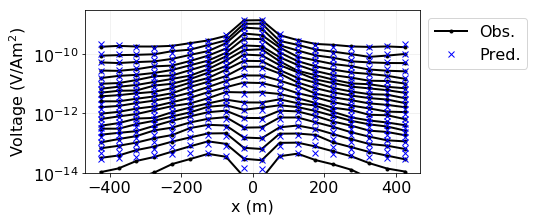

In [13]:
sigma = expmap * actmap * m
fig = plt.figure(figsize=(6, 3))
for itime in range(rx_z.times.size):
    plt.semilogy(x, -DOBS[:,0,itime], 'k.-', lw=2)
    plt.semilogy(x, -DPRED[:,itime], 'bx', lw=2)
plt.legend(("Obs.", "Pred."), bbox_to_anchor=(1,1))
plt.xlabel("x (m)")
plt.ylabel("Voltage (V/Am$^2$)")
plt.grid(which="both", alpha=0.2)
plt.ylim(1e-14, 3e-9)

Text(0.5,1,u'2D inversion')

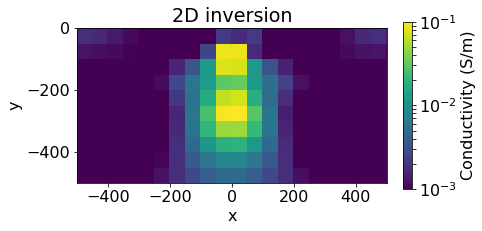

In [14]:
fig = plt.figure(figsize=(5, 3))
out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))
cb = plt.colorbar(out[0], fraction=0.025)
plt.ylim(-500, 0.)
plt.gca().set_aspect(1)
plt.xlim(-500, 500)
plt.ylim(-500, 0)
cb.set_label('Conductivity (S/m)')
plt.title("2D inversion")

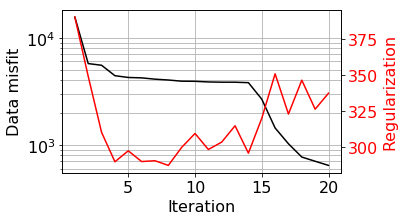

In [15]:
fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)
ax_1 = ax.twinx()
ax.semilogy(results[:,0], results[:,2], 'k-')
ax_1.plot(results[:,0], results[:,3], 'r-')
ax.set_xlabel("Iteration")
ax.set_ylabel("Data misfit")
ax_1.set_ylabel("Regularization", color='red')
for tl in ax_1.get_yticklabels():
    tl.set_color('r')
ax.grid(which='both')

In [16]:
def rect2D(p1, p2):    
    xy = np.c_[np.r_[p1[0], p2[0], p2[0], p1[0], p1[0]], np.r_[p1[1], p1[1], p2[1], p2[1], p1[1]]]
    return xy

In [17]:
p1 = np.r_[-50, -450]
p2 = np.r_[50, -50]
xy_box = rect2D(p1, p2)

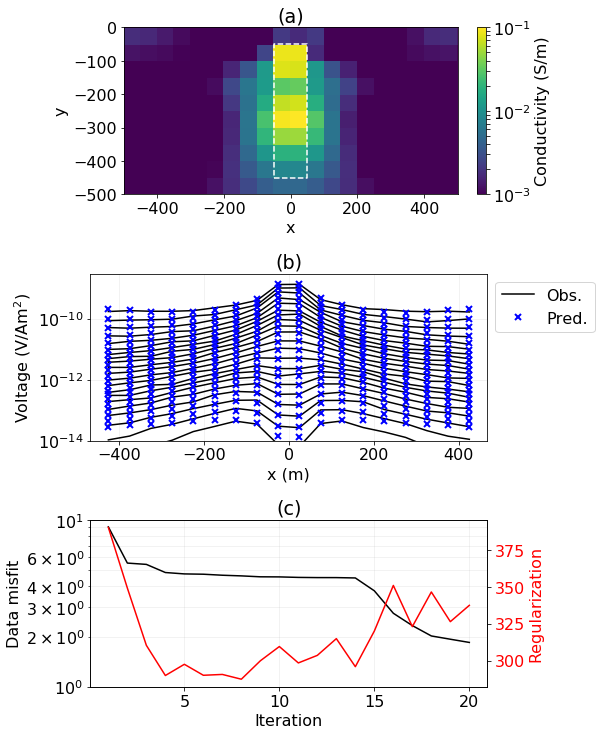

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(8, 3.5*3))

out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1), ax=ax[0])
cb = plt.colorbar(out[0], fraction=0.025, ax=ax[0])
ax[0].set_ylim(-500, 0.)
ax[0].set_aspect(1)
ax[0].set_xlim(-500, 500)
ax[0].set_ylim(-500, 0)
cb.set_label('Conductivity (S/m)')
ax[0].set_title("(a)")
ax[0].plot(xy_box[:,0], xy_box[:,1], 'w--')


for itime in range(rx_z.times.size):
    ax[1].semilogy(x, -DOBS[:,0,itime], 'k-')
    ax[1].semilogy(x, -DPRED[:,itime], 'bx', markeredgewidth=2)
ax[1].legend(("Obs.", "Pred."), bbox_to_anchor=(1,1))

ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("Voltage (V/Am$^2$)")
ax[1].grid(which="both", alpha=0.2)
ax[1].set_ylim(1e-14, 3e-9)
ax[1].set_title("(b)")

ax_1 = ax[2].twinx()
ax[2].semilogy(results[:,0], np.sqrt(results[:,2]/ (survey.nD/2.)), 'k-')
ax_1.plot(results[:,0], results[:,3], 'r-')
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Data misfit")
ax_1.set_ylabel("Regularization", color='red')
for tl in ax_1.get_yticklabels():
    tl.set_color('r')
ax[2].grid(which='both', alpha=0.2)
ax[2].set_title("(c)")
ax[2].set_ylim([1, 10 ])

plt.tight_layout()

In [19]:
def plot_model(iteration):
    sigma= expmap * actmap * model[iteration]
    fig = plt.figure(figsize=(5, 3))
    out = mesh_2d.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=(1e-3, 1e-1))
    cb = plt.colorbar(out[0], fraction=0.025)
#     plt.plot(xy_box[:,0], xy_box[:,1], 'w--')
    plt.ylim(-500, 0.)
    plt.gca().set_aspect(1)
    plt.xlim(-500, 500)
    plt.ylim(-500, 0)
    cb.set_label('Conductivity (S/m)')
    plt.title(("Iteration %i")%(iteration+1), fontsize = 17)
    plt.show()

In [20]:
from ipywidgets import interact, IntSlider
interact(plot_model, iteration=IntSlider(min=0, max=(len(model)-1)))

<function __main__.plot_model>

In [22]:
chi_fact = results[-1,2] / (survey.nD/2.)
rms = np.sqrt(chi_fact)
print (chi_fact, rms)

(3.3993121693121693, 1.8437223677420007)
